In [ ]:
"""
Software Name : QCSP Orange
SPDX-FileCopyrightText: Copyright (c) Orange SA
SPDX-License-Identifier: MIT

This software is distributed under the MIT License,
see the "LICENSE.txt" file for more details or https://spdx.org/licenses/MIT.html

Authors: 
    Louis-Adrien DUFRÈNE    louisadrien.dufrene@orange.com
    Guillaume LARUE         guillaume.larue@orange.com
    Quentin LAMPIN          quentin.lampin@orange.com

Software description: Orange study on the combination of CCSK and OFDM modulation. Part of the QCSP ANR project. See Deliverable D2.5b_OFDM-CCSK.pdf
"""

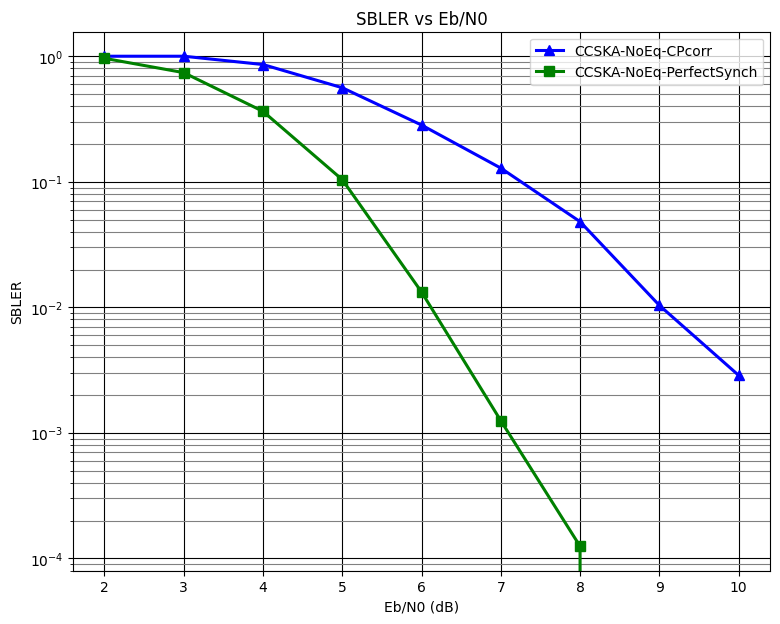

In [9]:
import pandas as pd
import glob

from utils import plot_list_dataframe_ber_bler


current_study = './study_test/results'

index = 'ebn0' # 'ebn0' or 'snr'
which = 'sbler' # 'ber' or 'bler' or 'ser' or 'sbler' or 'sample_offset' or 'fractional_frequency_offset'

files = glob.glob(f'{current_study}*.h5')
summary = []
for file in files:
    result = pd.read_hdf(file) 
    
    if index == 'snr':
        result.set_index('SNR', drop=True, append=False, inplace=True)
    else:
        result.pop('SNR')

    summary.append(result)

plot_list_dataframe_ber_bler(summary, save_path=f'{current_study}_{which}_vs_{index}.png', title=None, which=which, index=index, figsize=(9,7));


/tmp/ipykernel_1470909/1967670974.py:127: RuntimeWarning: divide by zero encountered in log
  y_max_limit = 10**(np.ceil(np.log(y_max)/np.log(10)))   # Round up
/tmp/ipykernel_1470909/1967670974.py:128: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(y_min_limit, y_max_limit)


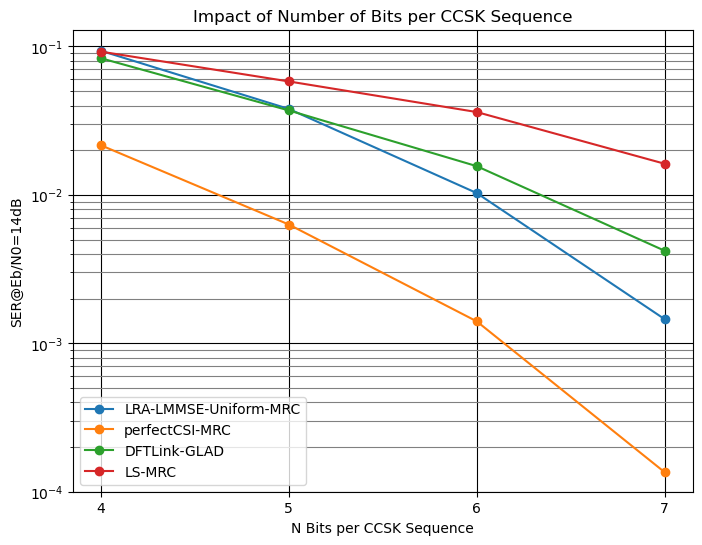

In [6]:
import pandas as pd
import glob

from utils import plot_list_dataframe_ber_bler

import matplotlib.pyplot as plt
import numpy as np
import itertools

import re

current_study = './study_ofdm_ccsk_oversampling/results'

index = 'ebn0' # 'ebn0' or 'snr'
which = 'ser' # 'ber' or 'bler' or 'ser' or 'sbler' or 'sample_offset' or 'fractional_frequency_offset'
at_snr = 14
    
 
def extract_number(filename):
    # Use regular expression to extract the numeric part of the filename
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    else:
        return 0

def extract_model_name(filename):
    match_results = re.search(r'results_', filename).span()
    match_digit= re.search(r'-\d+-bits', filename).span()
    match_h5 = re.search(r'.h5', filename).span()
    model_name = filename[match_results[1]:match_digit[0]]+filename[match_digit[1]:match_h5[0]]
    
    return model_name 
    

files = sorted(glob.glob(f'{current_study}*.h5'), key=extract_number)

y = []
x = [extract_number(filename) for filename in files]
names = [extract_model_name(filename) for filename in files]


results_dict = {}
for file in files:

    result = pd.read_hdf(file)
    
    if index == 'snr':
        result.set_index('SNR', drop=True, append=False, inplace=True)
    else:
        result.pop('SNR')

    filtered_df = result.loc[:,pd.IndexSlice[:, which,"mean"]]
    filtered_df_keys = filtered_df.keys()
    filtered_df = filtered_df[filtered_df_keys[0]][at_snr]

    y.append(filtered_df)


for i in range(len(y)):
    model = names[i]
    num_ofdm_symb = x[i]
    result = y[i]

    if model in results_dict.keys():
        results_dict[model].append((num_ofdm_symb,result))
    else:
        results_dict[model] = [(num_ofdm_symb,result)]



# Create a new figure with a specific size
plt.figure(figsize=(8, 6))

y_min = np.inf
y_max = 0

for model, data in results_dict.items():
    x, y = zip(*data)

    if min(y) < y_min:
        y_min = min(y)

    if max(y) < y_max:
        y_max = max(y)

    plt.plot(x, y, marker='o',label=model)#, color='blue', linestyle='--'

# Set the x and y axis labels
plt.xlabel('N Bits per CCSK Sequence')
plt.ylabel('SER@Eb/N0={}dB'.format(at_snr))

# Set the title
plt.title('Impact of Number of Bits per CCSK Sequence')

# Add a legend
plt.legend()#loc='upper left')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Display integer x-ticks
plt.xticks(range(int(min(x)), int(max(x)) + 1))

# Display the grid lines
plt.grid(True, which='major', color='black')#, linestyle='--', alpha=0.7)
plt.grid(True, which='minor', color='gray')#, linestyle=':', alpha=0.5)

# Calculate the y-axis limits to cover at least one decade
y_min_limit = 10**(np.floor(np.log(y_min)/np.log(10)))  # Round down 
y_max_limit = 10**(np.ceil(np.log(y_max)/np.log(10)))   # Round up 
plt.ylim(y_min_limit, y_max_limit)

save_path=f'{current_study}_at_{at_snr}_dB.png'
plt.savefig(save_path)

# Show the plot
plt.show()
    
#plot_list_dataframe_ber_bler(summary, save_path=f'{current_study}_{which}_vs_{index}.png', title=None, which=which, index=index, figsize=(9,7));
